# Visualization & Plot maker
This notebook loads the results and visualizes them. The outputs of this notebook are plots located in the "../plots" directory for the paper and presentation.


## Load results

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
# Load the CSV file into a pandas DataFrame
from datetime import datetime

import numpy as np

# Set the aesthetics for the seaborn plots
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_palette("Set2")
plt.rcParams.update({"xtick.labelsize": 17, "ytick.labelsize": 17,
"axes.titlesize": 18, "axes.titleweight": 'bold', "axes.labelsize": 19, "axes.labelweight": 'bold'})
pd.set_option('display.max_columns', 50)


In [2]:
def load_dataframe(path="../results/all_results.csv", columns=None):
    # Load the DataFrame
    df = pd.read_csv(path)
    # Convert the 'timestamp' column to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d_%H-%M-%S')

    # Select only the specified columns if the 'columns' parameter is provided
    if columns is not None:
        df = df[columns]

    # Remove rows where 'total weight' is NaN
    df = df.dropna(subset=['total_weights'])
    df = df[(df.regularization != 'dropout') & (df.regularization != 'l_infinty')]
    return df

def create_pivot_table(df, model_name, dataset_name, regularization, metric='test_loss'):
    # Filter the DataFrame based on the input parameters
    filtered_df = df[(df['model_name'] == model_name) & 
                     (df['dataset_name'] == dataset_name) & 
                     (df['regularization'] == regularization)]

    # List of bit widths to consider
    bit_widths = [32, 16, 8, 4, 2]

    # Create a new DataFrame for the pivot table
    pivot_data = []

    for bit in bit_widths:
        if bit == 32:
            # For bit width 32, use the 'test_loss' column
            col_name = metric
        else:
            # For other bit widths, use the 'bit_{i}_{metric}' format
            col_name = f'bit_{bit}_{metric}'

        # Check if the column exists in the DataFrame
        if col_name in filtered_df.columns:
            # Extract the required values and add to the pivot data
            for index, row in filtered_df.iterrows():
                pivot_data.append({'Bit Width': f'bit_{bit}', 
                                   'Regularization Param': row['regularization_param'], 
                                   metric: row[col_name]})

    # Convert the list of data into a DataFrame
    pivot_df = pd.DataFrame(pivot_data)

    # Sort the DataFrame by 'Bit Width' in descending order
    pivot_df['Bit Width'] = pd.Categorical(pivot_df['Bit Width'], 
                                           categories=[f'bit_{b}' for b in bit_widths], 
                                           ordered=True)
    pivot_df = pivot_df.sort_values('Bit Width', ascending=False)

    # Create the pivot table
    pivot_table = pivot_df.pivot(index='Bit Width', columns='Regularization Param', values=metric)

    return pivot_table

def my_eval(x):
    try:
        return eval(x)
    except:
        print(x)
        return x



In [11]:
cols = ['total_weights','model_name', 'dataset_name','regularization', 'regularization_param','optimizer_name',
 'train_loss', 'test_loss', 'train_accuracy', 'test_accuracy','lr', "epoch_test_losses",'path'] + [f'bit_{i}_test_accuracy' for i in [16, 8, 4, 2]]
df = load_dataframe(columns = cols)
df.shape

(38, 17)

## Accuracy Heatmaps

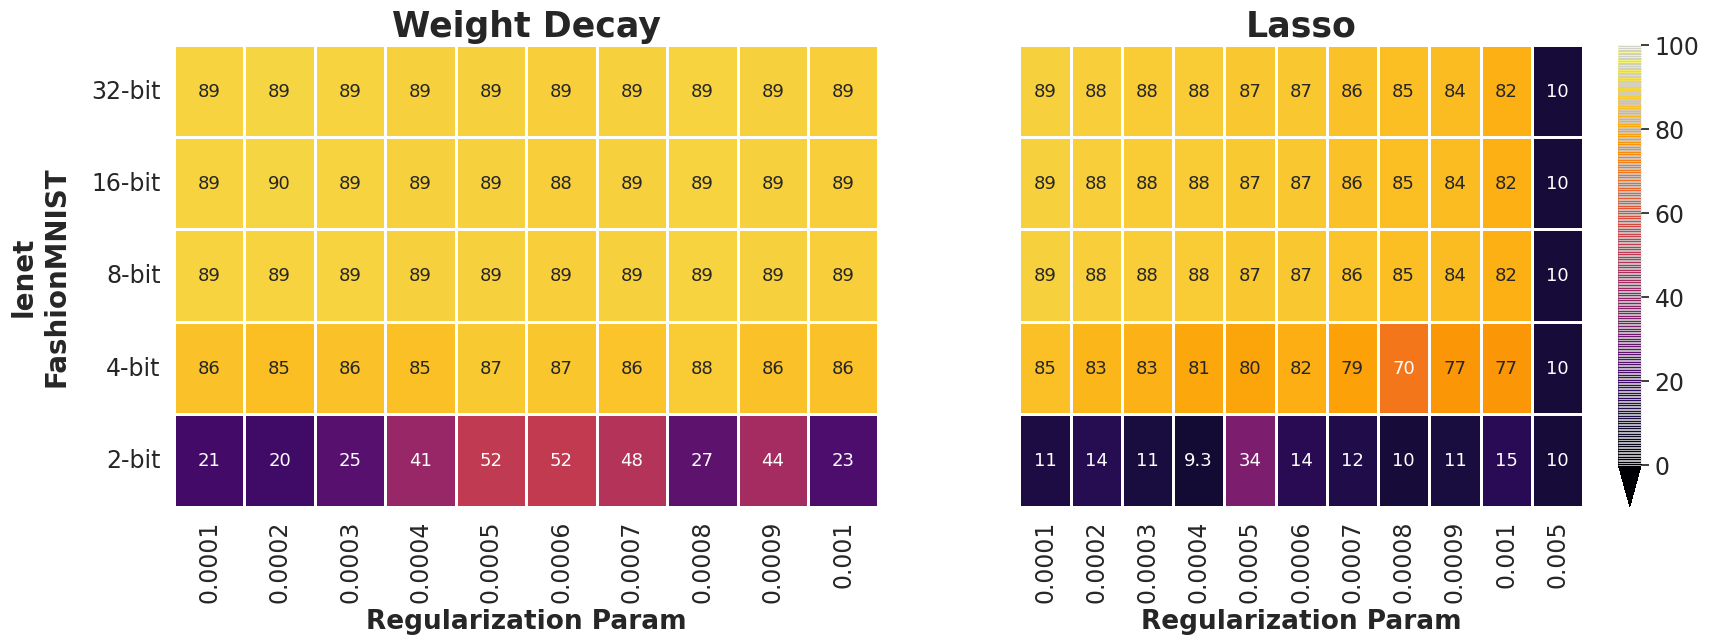

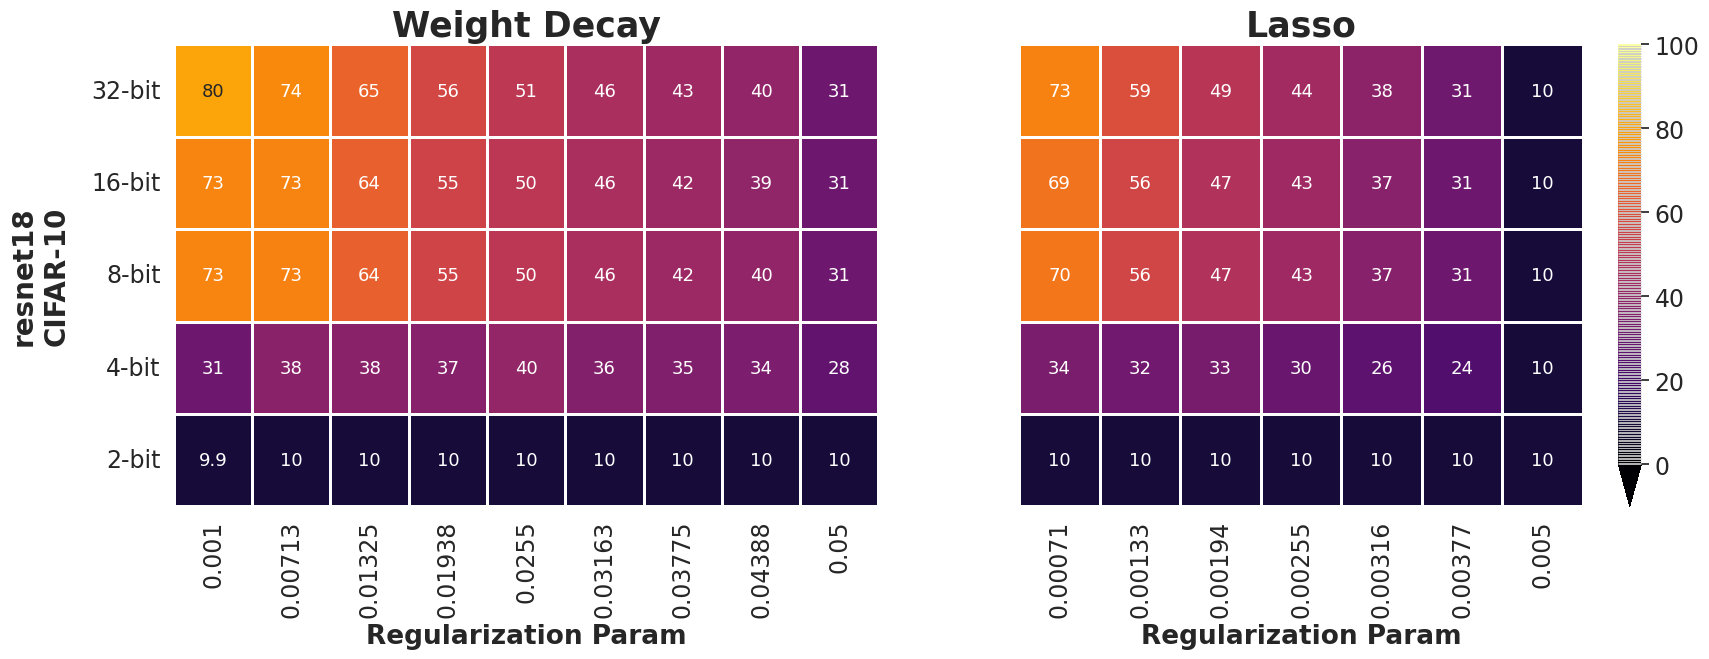

In [72]:


def plot_heatmap(ax, pivot_table, regularization, metric, set_ylabel=True, set_xlabel=True, 
                 model_name='', dataset_name='', title="", show_cbar=True):
    cbar_kws = {"orientation": "vertical", 
                "shrink": 1,
                'extend': 'min', 
                'extendfrac': 0.1, 
                "drawedges": True}

    # Plot heatmap
    sns.heatmap(pivot_table, annot=True, vmin=0, vmax=100, fmt=".2g", annot_kws={'size': 13}, 
                linewidths=1, cmap="inferno", cbar_kws=cbar_kws if show_cbar else None, 
                ax=ax, cbar=show_cbar)

    # Dictionary for renaming tick labels
    rename_dict = {'bit_2': '2-bit', 'bit_4': '4-bit', 'bit_16': '16-bit', 'bit_32': '32-bit', 'bit_8': "8-bit"}

    # Set custom tick labels for quantization levels
    ax.set_xticklabels([rename_dict.get(label.get_text(), label.get_text()) for label in ax.get_xticklabels()])
    if set_ylabel:
        ax.set_yticklabels([rename_dict.get(label.get_text(), label.get_text()) for label in ax.get_yticklabels()], rotation=0)
        ax.set_ylabel(f"{model_name}\n{dataset_name}", rotation=90, labelpad=15, fontsize=20)
    else:
        ax.set_ylabel('')
        ax.set_yticks([])
    if not set_xlabel:
        ax.set_xlabel('')
    if title:
        ax.set_title(title, fontsize=25)




metric = 'test_accuracy'
unique_datasets = df['dataset_name'].drop_duplicates().dropna()

for dataset_name in unique_datasets:
    # Filter the unique combinations of model_name and regularization for this dataset
    unique_pairs = df[df['dataset_name'] == dataset_name][['model_name', 'regularization']].drop_duplicates().dropna()

    # Number of plots (subplots) needed for this dataset
    n_plots = 2

    # Create a figure with multiple subplots
    fig, axes = plt.subplots(1, n_plots, figsize=(10 * n_plots, 6))  # Adjust the size as needed
    titles={"l2":"Weight Decay", "l1":'Lasso'}
    for i, (model_name, regularization) in enumerate(unique_pairs.values):
        if regularization != "none":
            tmp = df[
                (df.model_name == model_name) & (df.dataset_name == dataset_name) & (df.regularization == regularization)
            ]
            pivot_table = create_pivot_table(tmp, model_name, dataset_name, regularization, metric)

            # Plot heatmap in the ith subplot
            if n_plots > 1:
                ax = axes[i]
            else:
                ax = axes  # If there's only one plot, axes is not a list
            plot_heatmap(ax, pivot_table, regularization, metric, (i==0), True, model_name, dataset_name, title=titles[regularization], show_cbar=(i!=0))

    # Save the entire figure as a PNG file
    fig.savefig(f"../plots/test_accuracy_{dataset_name}.png", bbox_inches='tight')
    plt.show()  # Display the figure

    # This loop will create a single figure for each dataset, with multiple subplots in a row


## Distribution shift

In [15]:
from src.models.model_registry import create_model
from torch import load
import torch 


model = create_model("resnet20")

In [65]:
df.groupby(["model_name", "dataset_name"]).total_weights.mean()

model_name  dataset_name
lenet       FashionMNIST       44426.0
resnet18    CIFAR-10        11172042.0
Name: total_weights, dtype: float64

In [146]:
before, after = df[(df.dataset_name == "CIFAR-10") & (df.regularization == "l2")].sort_values('regularization_param').iloc[[0, -1]].path


checkpoint_path_before = os.path.join(before, "model_checkpoint.pth")
checkpoint_path_after = os.path.join(after, "model_checkpoint.pth")

state_dict_before = load(checkpoint_path_before, map_location=torch.device('cpu'))
state_dict_after = load(checkpoint_path_after, map_location=torch.device('cpu'))

<Axes: ylabel='Density'>

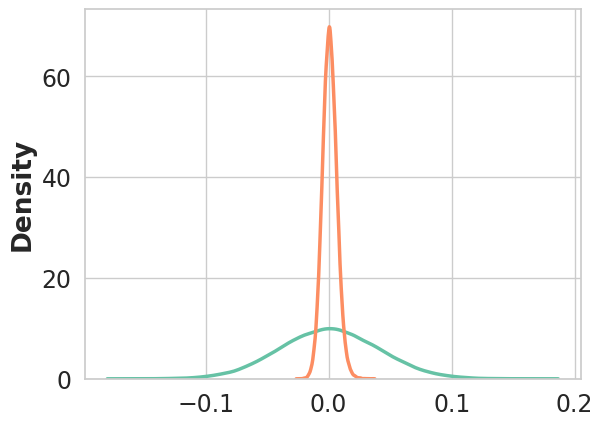

In [162]:
layer = 'model.layer2.0.conv1.weight'
sns.kdeplot(state_dict_before[layer].flatten(), label = "before")

layer = 'model.layer2.0.conv1.weight'
sns.kdeplot(state_dict_after[layer].flatten(), label="after")

In [153]:
for j in state_dict_before:
    print(j, state_dict_before[j].flatten().shape[0])

model.conv1.weight 9408
model.layer1.0.conv1.weight 36864
model.layer1.0.conv2.weight 36864
model.layer1.1.conv1.weight 36864
model.layer1.1.conv2.weight 36864
model.layer2.0.conv1.weight 73728
model.layer2.0.conv2.weight 147456
model.layer2.0.downsample.0.weight 8192
model.layer2.1.conv1.weight 147456
model.layer2.1.conv2.weight 147456
model.layer3.0.conv1.weight 294912
model.layer3.0.conv2.weight 589824
model.layer3.0.downsample.0.weight 32768
model.layer3.1.conv1.weight 589824
model.layer3.1.conv2.weight 589824
model.layer4.0.conv1.weight 1179648
model.layer4.0.conv2.weight 2359296
model.layer4.0.downsample.0.weight 131072
model.layer4.1.conv1.weight 2359296
model.layer4.1.conv2.weight 2359296
model.fc.weight 5120
model.fc.bias 10


In [132]:
def quantize_weights(full_precision_weights, scale, zero_point):
    quantized_weights = (full_precision_weights - zero_point) / scale
    return quantized_weights

state_dict = state_dict_after
# Example for a single layer
full_precision_weights = state_dict['model.layer1.0.conv1.weight']
scale = state_dict['model.layer1.0.relu.act_quant.fused_activation_quant_proxy.tensor_quant.scaling_impl.value']
zero_point = state_dict['model.layer1.0.relu.act_quant.fused_activation_quant_proxy.tensor_quant.zero_point_impl.value']

quantized_weights = quantize_weights(full_precision_weights, scale, zero_point)


In [133]:
quantized_weights[0][0]

tensor([[-0.0008,  0.0038,  0.0007],
        [ 0.0060,  0.0027,  0.0090],
        [ 0.0067,  0.0066,  0.0010]])

In [134]:
full_precision_weights[0][0]

tensor([[-0.0011,  0.0053,  0.0009],
        [ 0.0084,  0.0037,  0.0126],
        [ 0.0094,  0.0093,  0.0014]])

In [105]:
# Extract the floating-point weights for layer2 from the before state dict
fp_weights = state_dict_before['model.fc.weight'].flatten().numpy()

# Extract the quantized integer weights for layer2 from the after state dict
int_weights = state_dict_after['model.fc.weight'].flatten().numpy()
(int_weights == fp_weights).all()

True

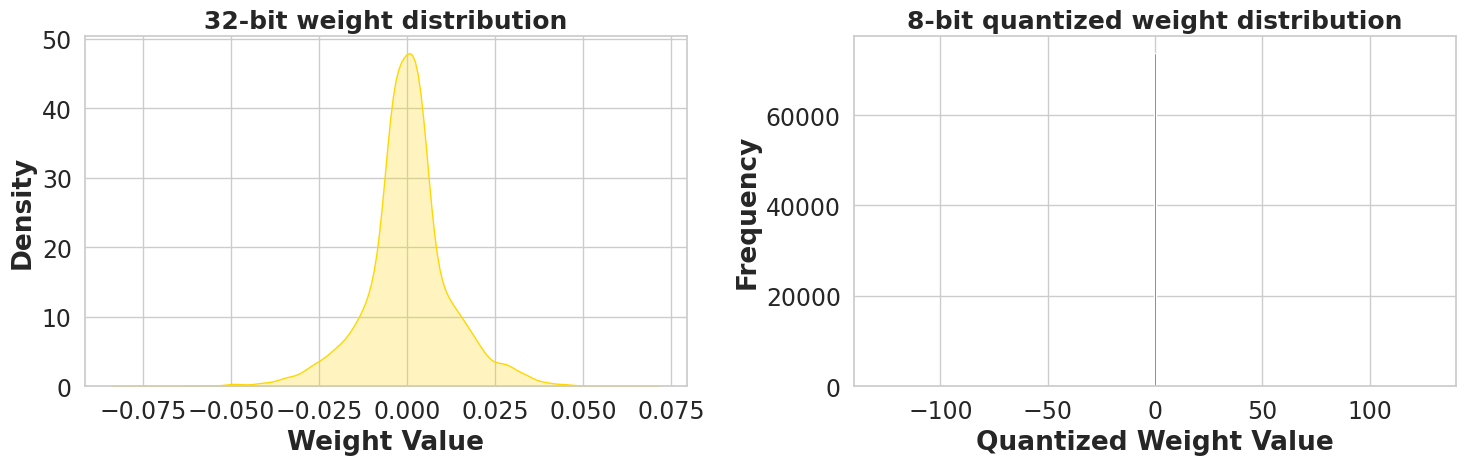

In [113]:
# Now you can plot the distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot the original weights
sns.kdeplot(fp_weights, ax=axes[0], fill=True, color='gold')
axes[0].set_title('32-bit weight distribution')
axes[0].set_xlabel('Weight Value')
axes[0].set_ylabel('Density')

# Plot the quantized weights
# Depending on the range of the quantized weights, you might need to set the bins appropriately
# bins = range(min(int_weights), max(int_weights) + 1)
axes[1].hist(int_weights, bins=255, color='red', range=(-127.5, 127.5))  # Assuming 8-bit quantization
axes[1].set_title('8-bit quantized weight distribution')
axes[1].set_xlabel('Quantized Weight Value')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

array([0], dtype=int32)